# Fashion MNIST: Loading & Preprocessing Data

In [207]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torchvision.models import alexnet, AlexNet_Weights, inception_v3, Inception_V3_Weights, vgg16, VGG16_Weights
from torchvision.transforms import v2
import torch.optim as optim
from torch.optim import lr_scheduler
import os
from tempfile import TemporaryDirectory

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [208]:
class TensorBoardLogger:
    def __init__(self, log_dir):
        self.summary_writer = SummaryWriter(log_dir)

    def add_scalars(self, tag_step_value_dict):
        """
        :param parent_tag: str, e.g. "Training Loss"
        :param tag_step_value_dict: dict, e.g., {"key":(step, value), "q_grad":(10000, 1.11)}
        """
        for tag, (step, value) in tag_step_value_dict.items():
            self.summary_writer.add_scalar(tag, value, step)

In [209]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Train, Validation, Test datasets

In [210]:
import torch.utils
import torch.utils.data


train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))

seed = torch.Generator().manual_seed(42)
train_portion = 0.9
test_portion = 0.1

print(len(train_set))

train_set, valid_set = torch.utils.data.random_split(train_set,[train_portion,test_portion], seed)



test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

60000


In [211]:
#Create Dataset Class
class FashionMNISTDataset(Dataset):
    def __init__(self,data) -> None:
        super().__init__()

        #construct attributes for the features and labels in the dataset
        x = []
        y = []

        for i in range(len(data)):
            x.append(data[i][0])
            y.append(data[i][1])

        

        self.x = torch.stack(x)
        self.y = torch.Tensor(y)
        self.y = self.y.type(dtype=torch.LongTensor)

    def __getitem__(self, index):
        image = self.x[index]
        label = self.y[index]

        return image, label

    def __len__(self):
        return len(self.x)

In [212]:
train_dataset = FashionMNISTDataset(train_set)
valid_dataset = FashionMNISTDataset(valid_set)
test_dataset = FashionMNISTDataset(test_set)

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=100)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

dataloaders = {"train" : [train_loader,len(train_dataset)],
               "valid" : [valid_loader,len(valid_dataset)],
               "test" : [test_loader,len(test_loader)]

}

In [213]:
fashion_mnist_labels = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

In [214]:
labels_size = len(fashion_mnist_labels.keys())

In [215]:
def imshow(inp, normalized_image : str = False, title=None):
    """Display image for Tensor."""
    #inp = inp.numpy().transpose((-1,1, 2, 0))
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    if not normalized_image:
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([10, 1, 28, 28])
torch.Size([3, 62, 242])
['Ankle Boot', 'Pullover', 'Sandal', 'T-shirt/Top', 'Sandal', 'Trouser', 'Dress', 'Sandal', 'T-shirt/Top', 'Trouser']


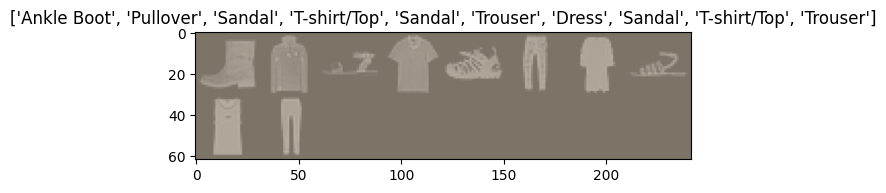

In [216]:
# Get a batch of training data

demo_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch

print(images.shape)
# Make a grid from batch
out = torchvision.utils.make_grid(images)
print(out.shape)

title = [fashion_mnist_labels[int(x)] for x in labels]
print(title)
imshow(out, title=title)

In [217]:
dataloaders["valid"][1]

6000

In [218]:
def model_params_mode(model,mode : str):
    """
    This functino freezes/unfreezes model parameters depending on the desired input
    """
    if mode == "freeze":
        grad = True
    else:
        grad = False

    for param in model.parameters():
            param.requires_grad = grad



In [219]:
def update_model(model,out_dim : int, model_name : str):
    """
    This function modifies the model architecture to be compatible with the fashion MNIST output layer
    """

    

    if model_name == "AlexNet":
        in_features = model.classifier[1].in_features
    elif model_name == "VGG":
        in_features =  model.classifier[0].in_features

    model.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(in_features,out_dim),
        nn.Softmax(dim=-1)
    )

    return model



In [220]:
class Model(nn.Module):
    def __init__(self, base_model,neurons : list,base_model_name : str = None) -> None:
        super().__init__()
        self.base_model = base_model
        self.base_model_name = base_model_name
        self.neurons = neurons
        self.replaceOutputLayer()
        

    def replaceOutputLayer(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

        last_layer = None
        if self.base_model_name == "AlexNet": 

            old_out_features = self.base_model.classifier[6].out_features
            #self.base_model.classifier = nn.Linear(old_in_features,self.neurons[1])
            
        self.out_layer_1 = nn.Linear(old_out_features,self.neurons[1])



    def forward(self,x):
        x = self.base_model(x)
        return self.out_layer_1(x)



In [221]:
transform_im = v2.Compose([
    v2.RandomResizedCrop(size=(299, 299), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 604, 2410])


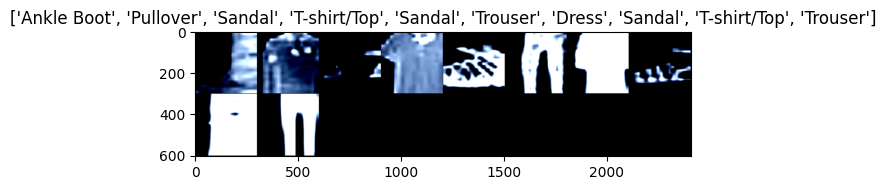

In [222]:
demo_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch
images = transform_im(images)

# Make a grid from batch
out = torchvision.utils.make_grid(images)
print(out.shape)

title = [fashion_mnist_labels[int(x)] for x in labels]

imshow(out,True, title=title)

In [223]:
def train_model(model, criterion, optimizer,dataloaders,weight_dir,logger : TensorBoardLogger,scheduler = None, num_epochs=25,debug = False):
        since = time.time()

   
        os.makedirs(weight_dir, exist_ok=True)
        best_model_params_path = os.path.join(weight_dir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        log_vars = {}


        for epoch in range(num_epochs):

            log_vars.update({
                "learning_rate" : (epoch,scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr'])
            }
            )


            if debug:
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase][0]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(transform_im(inputs))
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                if phase == 'train' and scheduler:
                    scheduler.step()

                epoch_loss = running_loss / dataloaders[phase][1]
                epoch_acc = running_corrects.double() / dataloaders[phase][1]

                if debug:
                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}\n')

                # deep copy the model
                if phase == 'valid' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

                log_vars.update(
                    {f"{phase}/Loss" : (epoch,epoch_loss),
                                      f"{phase}/Accuracy" : (epoch,epoch_acc.cpu().numpy())
                    }
                )
                
                logger.add_scalars(log_vars)
        

        time_elapsed = time.time() - since
        if debug:
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        return model

In [224]:
def test_model(model,logger : TensorBoardLogger):
    model.eval()

    log_vars = {}

    tot_accurate_pred = 0


    for i,(image,labels) in enumerate(dataloaders["test"][0]):
        image,labels = image.to(device),labels.to(device)

        #predictions...
        with torch.no_grad():
            predictions = model(transform_im(image))
            _,predictions = torch.max(predictions,dim=-1)
            accurate_pred = torch.sum(predictions == labels.data)


        log_vars.update(
            {
                "Test/Accuracy_Batch" : (i, accurate_pred.double().cpu().numpy() / image.shape[0])
            }
        )

        logger.add_scalars(log_vars)

        tot_accurate_pred += accurate_pred.double().cpu().numpy()

    log_vars.update(
            {
                "Test/Accuracy_Tot" : (0, tot_accurate_pred / dataloaders["test"][1])
            }
        )
    
    logger.add_scalars(
        {
                "Test/Accuracy_Tot" : (0, tot_accurate_pred / dataloaders["test"][1])
            }
    )
    





# AlexNet for Image Classification : Fashion MNIST

In [225]:
alexnet_model = alexnet(AlexNet_Weights.DEFAULT)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [226]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [227]:
model_params_mode(alexnet_model,"freeze")
alexnet_model = update_model(alexnet_model,labels_size,"AlexNet")

In [228]:
alexnet_model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=10, bias=True)
   

In [229]:
demo_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=10)
batch = next(iter(demo_loader))
images, labels = batch
inputs = transform_im(images)
with torch.no_grad():
    inputs,labels = inputs.to(device), labels.to(device)
    alexnet_model.to(device)
    alexnet_model.eval()
    outputs = alexnet_model(inputs)
outputs

tensor([[0.0873, 0.0777, 0.1079, 0.1535, 0.0790, 0.0810, 0.1113, 0.1097, 0.1066,
         0.0859],
        [0.0926, 0.0743, 0.0994, 0.1050, 0.0981, 0.0807, 0.1440, 0.0969, 0.1094,
         0.0997],
        [0.1099, 0.0710, 0.1468, 0.0961, 0.1182, 0.0740, 0.1055, 0.0961, 0.0975,
         0.0849],
        [0.1154, 0.0765, 0.0819, 0.0851, 0.0678, 0.0883, 0.1562, 0.0967, 0.1164,
         0.1157],
        [0.1544, 0.1394, 0.0744, 0.0701, 0.1346, 0.0531, 0.0972, 0.0827, 0.0544,
         0.1397],
        [0.1108, 0.0481, 0.0716, 0.1112, 0.1233, 0.0659, 0.1378, 0.1439, 0.0857,
         0.1017],
        [0.1232, 0.0719, 0.0946, 0.0934, 0.0969, 0.0816, 0.1148, 0.0915, 0.1150,
         0.1171],
        [0.1391, 0.0790, 0.1128, 0.0969, 0.1293, 0.0643, 0.0852, 0.1059, 0.0806,
         0.1070],
        [0.1467, 0.0751, 0.1001, 0.0854, 0.0960, 0.0719, 0.1275, 0.1005, 0.1085,
         0.0884],
        [0.1128, 0.0556, 0.0946, 0.0982, 0.1115, 0.0647, 0.1521, 0.1191, 0.0942,
         0.0973]], device='c

## Training AlexNet for Image Classification : Fashion MNIST

In [230]:
alexnet_model= alexnet_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_alexnet = optim.Adam(alexnet_model.classifier.parameters(), lr=0.1)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.ExponentialLR(optimizer_alexnet,0.0001)
#lr_scheduler.StepLR(optimizer_alexnet, step_size=2, gamma=0.1)


In [231]:
dir = os.path.abspath(os.getcwd()) + "/model/AlexNet_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [232]:
alexnet_model = train_model(alexnet_model, criterion, optimizer_alexnet,
                         dataloaders,dir,logger,exp_lr_scheduler, num_epochs=30)

In [233]:
#Test in AlexNet FeatureExtractor
#log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FeatureExtractor_Test/"
#os.makedirs(log_dir, exist_ok=True)
#logger = TensorBoardLogger(log_dir)
test_model(alexnet_model,logger)

In [1]:
%tensorboard --logdir runs/

UsageError: Line magic function `%tensorboard` not found.


## Fine-Tuning AlexNet for Image Classification : Fashion MNIST

In [235]:
dir = os.path.abspath(os.getcwd()) + "/model/AlexNet/FineTune/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/AlexNet_FineTune/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [236]:
for param in alexnet_model.parameters():
    param.requires_grad = True

optimizer_alexnet = optim.Adam(alexnet_model.parameters(), lr=0.00001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_alexnet, step_size=1, gamma=0.1)

alexnet_model = train_model(alexnet_model, criterion, optimizer_alexnet,
                         dataloaders,dir,logger, num_epochs=20)

# VGG16 for Image Classification : Fashion MNIST

In [237]:
vgg_model = vgg16(VGG16_Weights.DEFAULT)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [238]:
model_params_mode(vgg_model,"freeze")
vgg_model = update_model(vgg_model,labels_size,"VGG")

## Training VGG16 for Image Classification : Fashion MNIST

In [240]:
vgg_model= vgg_model.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_alexnet = optim.Adam(vgg_model.classifier.parameters(), lr=0.1)

# Decay LR by a factor of 0.1 every 7 epochs

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_alexnet, step_size=2, gamma=0.05)

In [241]:
dir = os.path.abspath(os.getcwd()) + "/model/VGG_FE/"
log_dir = os.path.abspath(os.getcwd()) + "/runs/VGG_FE/"
os.makedirs(log_dir, exist_ok=True)
logger = TensorBoardLogger(log_dir)

In [242]:
vgg_model = train_model(vgg_model, criterion, optimizer_alexnet,
                         dataloaders,dir,logger,exp_lr_scheduler, num_epochs=30)

c:\Users\kevin\miniconda3\envs\neural_sys_fashion_mnist\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


## Fine-Tuning VGG16 for Image Classification : Fashion MNIST

# Training GoogleLenet for Image Classification : Fashion MNIST

# Fine-Tuning GoogleLenet for Image Classification : Fashion MNIST

# Training ResNet for Image Classification : Fashion MNIST

# Fine-Tuning ResNet for Image Classification : Fashion MNIST